## 0 - Pull in dependencies and initiate Duet session

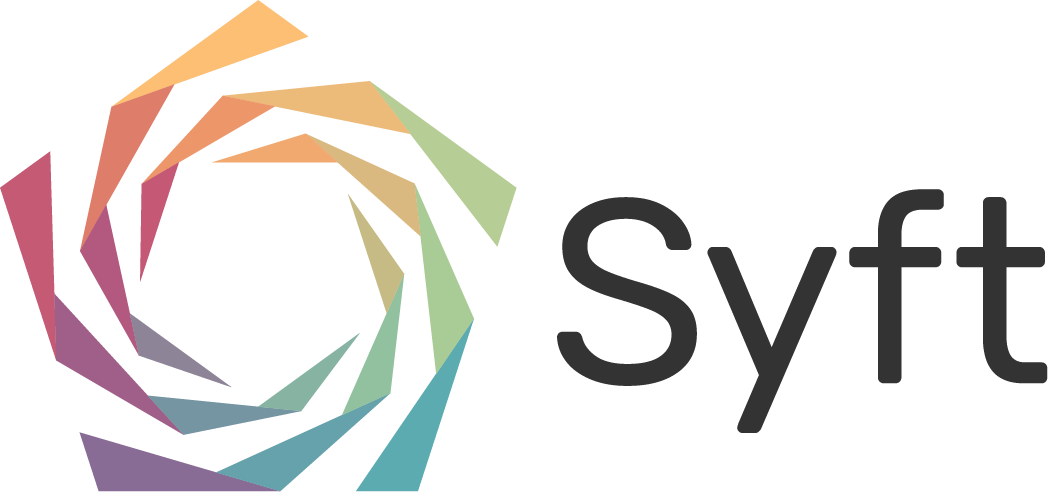

🎤  🎸  ♪♪♪ Joining Duet ♫♫♫  🎻  🎹

♫♫♫ > DISCLAIMER: Duet is an experimental feature currently in beta.
♫♫♫ > Use at your own risk.


    > ❤️ Love Duet? Please consider supporting our community!
    > https://github.com/sponsors/OpenMined

♫♫♫ > Punching through firewall to OpenGrid Network Node at:
♫♫♫ > http://ec2-18-216-8-163.us-east-2.compute.amazonaws.com:5000
♫♫♫ >
♫♫♫ > ...waiting for response from OpenGrid Network... 
♫♫♫ > DONE!

♫♫♫ > CONNECTED!


In [1]:
# First lets pull in our dependencies and initiate our duet session
import torch
import random
from torch import nn
from torch import optim
import syft as sy

duet = sy.join_duet(loopback=True)

## 1 - Define and send our remote assets

Here we'll define the remote model which will have the remote input data fed into it. This includes;

- Our first model segment
- Our dummy input data

In [7]:
remote_torch = duet.torch

random.seed(1)

# In order to serialise our model we need to define it as below
class SyNet(sy.Module):
    def __init__(self, torch_ref):
        super(SyNet, self).__init__(torch_ref=torch_ref)
        self.lin = self.torch_ref.nn.Linear(2,2)

    def forward(self, x):
        x = self.lin(x)
        return x
    
model1 = SyNet(torch)
model1_ptr = model1.send(duet)
opt1 = remote_torch.optim.SGD(params=model1_ptr.parameters(),lr=0.1)

In [8]:
duet.store.pandas

ID       Tags            Description  \
0  <UID: 44967aa078ac4e6db2f5503481bfe179>  [dataset]  simple binary dataset   

              object_type  
0  <class 'torch.Tensor'>

In [9]:
data_pointer = duet.store[0]

## 2 - Define and send our local assets

Here we'll define the remote model which will have the remote input data fed into it. This includes;

- Our second model segment
- Our dummy labels

In [10]:
model2 = nn.Linear(2,1)
opt2 = optim.SGD(params=model2.parameters(),lr=0.1)

target= torch.tensor([[0],[0],[1],[1.]])

## 3 - Define our training logic

In [11]:
for iter in range(20):
    opt1.zero_grad()
    opt2.zero_grad()
    
    activation_ptr = model1_ptr(data_pointer)
    activation_ptr.request(reason="process the model", timeout_secs = -1)
    activation = activation_ptr.clone().get()
    
    pred = model2(activation)
    loss = ((pred - target)**2).sum()
    loss.backward()
    
    grad_ptr = activation.grad.clone().send(duet)
    activation_ptr.backward(grad_ptr)

    opt1.step()
    opt2.step()
    
    print(loss)

tensor(5.5025, grad_fn=<SumBackward0>)
tensor(0.9720, grad_fn=<SumBackward0>)
tensor(0.6102, grad_fn=<SumBackward0>)
tensor(0.4262, grad_fn=<SumBackward0>)
tensor(0.3032, grad_fn=<SumBackward0>)
tensor(0.2028, grad_fn=<SumBackward0>)
tensor(0.1275, grad_fn=<SumBackward0>)
tensor(0.0761, grad_fn=<SumBackward0>)
tensor(0.0440, grad_fn=<SumBackward0>)
tensor(0.0250, grad_fn=<SumBackward0>)
tensor(0.0142, grad_fn=<SumBackward0>)
tensor(0.0082, grad_fn=<SumBackward0>)
tensor(0.0047, grad_fn=<SumBackward0>)
tensor(0.0028, grad_fn=<SumBackward0>)
tensor(0.0016, grad_fn=<SumBackward0>)
tensor(0.0010, grad_fn=<SumBackward0>)
tensor(0.0006, grad_fn=<SumBackward0>)
tensor(0.0003, grad_fn=<SumBackward0>)
tensor(0.0002, grad_fn=<SumBackward0>)
tensor(0.0001, grad_fn=<SumBackward0>)
